<a href="https://colab.research.google.com/github/jimgoo/medical/blob/main/fMRI/stylegan_recon_colab_v0.0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paul Scotti 2022

Change Log:
- v0.0.1: Cast inputs to TensorDatasets and style GAN to tensors, specify a data dir, can use gdrive for h5 files (Jimmie Goode)

In [1]:
!python --version

Python 3.7.13


In [2]:
!nvidia-smi

Fri Oct 28 16:22:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:04:00.0 Off |                  Off |
| 30%   31C    P8    14W / 230W |      1MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            115           1          84           0          29         112
Swap:             1           0           1


In [4]:
#ddir = './'
#ddir = '/content/drive/MyDrive/neuro'
ddir = '/workspace/data'

if 'MyDrive' in ddir:
    from google.colab import drive
    drive_path = "/content/drive"
    drive.mount(drive_path)

In [5]:
import os
files = ['subj01_nsdgeneral.hdf5', 'stylegan_projections.hdf5', 'COCO_73k_subj_indices.hdf5']
for f in files:
    if not os.path.exists(os.path.join(ddir, f)):
        !wget -c -P {ddir} https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/main/{f}

In [6]:
!du -h $ddir/*.hdf5

568K	/workspace/data/COCO_73k_subj_indices.hdf5
4.2G	/workspace/data/stylegan_projections.hdf5
7.6G	/workspace/data/subj01_nsdgeneral.hdf5


In [7]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import transforms
from tqdm import tqdm
import PIL
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# import lpips
# loss_fn = lpips.LPIPS(net='vgg').to(device)

def np_to_Image(x):
    return PIL.Image.fromarray((x.transpose(1, 2, 0)*127.5+128).clip(0,255).astype('uint8'))

def torch_to_Image(x, rescale=True):
    x = x.permute(0, 2, 3, 1)
    if rescale:
        x = x*127.5 + 128
    x = x.clamp(0, 255).to(torch.uint8).cpu().numpy()[0]
    return PIL.Image.fromarray(x)

def Image_to_torch(x):
    return (transforms.ToTensor()(x[0])[:3].unsqueeze(0)-.5)/.5

def torch_to_matplotlib(x, device=device):
    if torch.mean(x) > 10:
        x = (x.permute(0, 2, 3, 1)).clamp(0, 255).to(torch.uint8)
    else:
        x = (x.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    if device=='cpu':
        return x[0]
    else:
        return x.cpu().numpy()[0]

def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cuda


In [8]:
torch.__version__

'1.12.0'

# Load Data

In [9]:
# Load data
subj = 'subj01' # 37 sessions (each session = 750 images)
train_trials = np.arange(750*37 - 200)
val_trials = np.arange(750*37 - 200, 750*37)

f = h5py.File(os.path.join(ddir, f'{subj}_nsdgeneral.hdf5'), 'r')
train_voxels = f['voxels'][train_trials]
val_voxels = f['voxels'][val_trials]
print("Voxels loaded.")

Voxels loaded.


In [10]:
750*37, 23715 + 8364

(27750, 32079)

In [11]:
f['voxels'].shape

(27750, 15724)

In [12]:
f['images'].shape

(27750, 256, 256, 3)

In [13]:
train_trials.shape, val_trials.shape

((27550,), (200,))

In [14]:
train_voxels.shape, val_voxels.shape

((27550, 15724), (200, 15724))

In [15]:
f = h5py.File(os.path.join(ddir, 'COCO_73k_subj_indices.hdf5'), 'r')
all_73KID = f[subj]

train_ind = all_73KID[train_trials]
_, train_ind_order = np.unique(train_ind, return_inverse=True)

val_ind = all_73KID[val_trials]
_, val_ind_order = np.unique(val_ind, return_inverse=True)

print("Trial indices loaded.")

Trial indices loaded.


In [16]:
all_73KID.shape

(27750,)

In [17]:
np.unique(all_73KID).shape

(9841,)

In [18]:
train_ind.shape, val_ind.shape

((27550,), (200,))

In [19]:
f = h5py.File(os.path.join(ddir, 'stylegan_projections.hdf5'), 'r')
train_embs = f['projections'][np.unique(np.sort(train_ind))]
val_embs = f['projections'][np.unique(np.sort(val_ind))]
train_embs = train_embs[train_ind_order]
val_embs = val_embs[val_ind_order]
print("Embeddings loaded.")

Embeddings loaded.


In [20]:
f['projections'].shape

(73000, 32, 512)

In [21]:
train_embs.shape, val_embs.shape

((27550, 32, 512), (200, 32, 512))

In [22]:
# ensuring no validation trials w/ images presented in training data
exclude_repeats = ~np.isin(val_ind, train_ind)

In [23]:
np.where(exclude_repeats)[0].shape

(40,)

In [24]:
val_voxels = val_voxels[exclude_repeats] 
val_embs = val_embs[exclude_repeats]

#del all_73KID # no longer needed
f.close() # close the hdf5 file

print(train_voxels.shape, train_embs.shape)
print(val_voxels.shape, val_embs.shape)

assert len(train_voxels) == len(train_embs)
assert len(val_voxels) == len(val_embs)

(27550, 15724) (27550, 32, 512)
(40, 15724) (40, 32, 512)


In [25]:
len(val_voxels) / len(train_voxels)

0.0014519056261343012

In [26]:
32 * 512

16384

In [27]:
np.min(train_voxels), np.max(val_voxels)

(-39010.418, 19531.146)

In [28]:
np.min(train_embs), np.max(val_embs)

(-6.820217, 5.4745855)

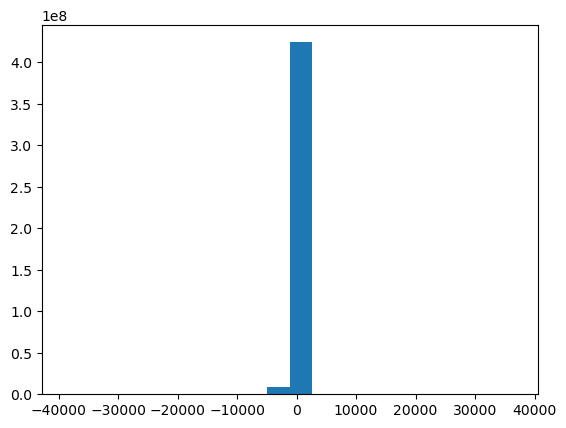

In [29]:
plt.hist(train_voxels.ravel(), bins=20);

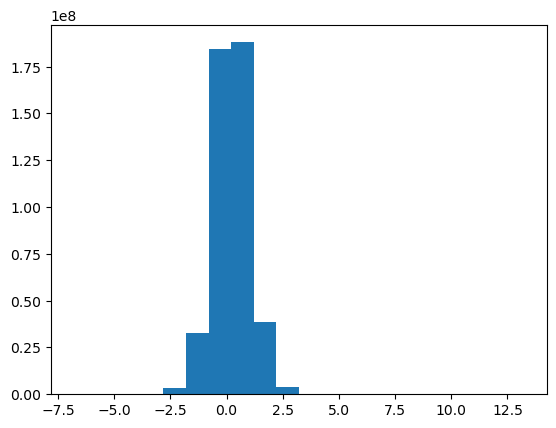

In [30]:
plt.hist(train_embs.ravel(), bins=20);

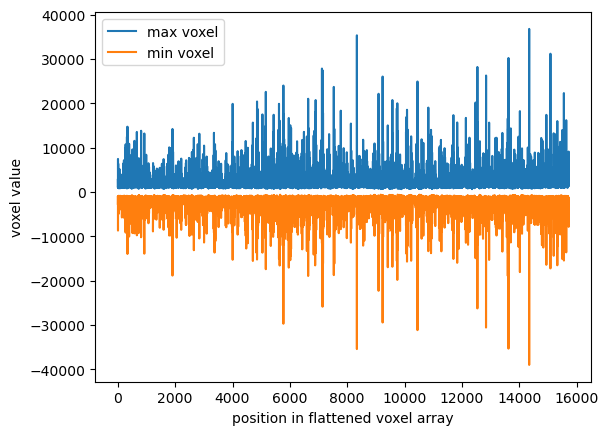

In [48]:
plt.plot(np.vstack((np.max(train_voxels, 0), np.min(train_voxels, 0))).T);
plt.legend(['max voxel', 'min voxel']);
plt.xlabel('position in flattened voxel array');
plt.ylabel('voxel value');

In [35]:
train_voxels.ravel().shape

(433196200,)

In [31]:
from sklearn.preprocessing import RobustScaler

In [32]:
sc_vox = RobustScaler()
sc_vox.fit(train_voxels)

RobustScaler()

In [33]:
train_voxels_sc = sc_vox.transform(train_voxels)
val_voxels_sc = sc_vox.transform(val_voxels)

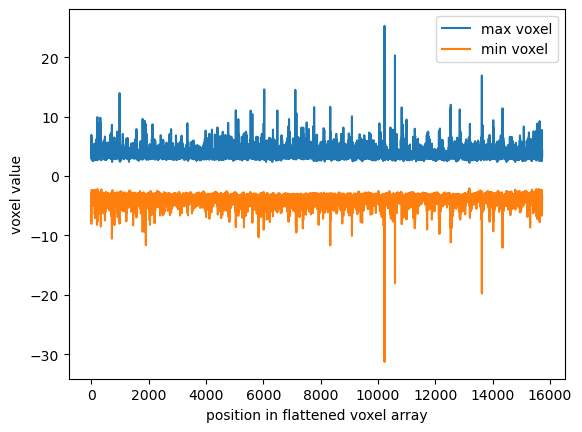

In [55]:
plt.plot(np.vstack((np.max(train_voxels_sc, 0), np.min(train_voxels_sc, 0))).T);
plt.legend(['max voxel', 'min voxel']);
plt.xlabel('position in flattened voxel array');
plt.ylabel('voxel value');

# Create / Train Model

In [62]:
# set seeds to keep things reproducible and stay sane
torch.manual_seed(0)
np.random.seed(0)

# create network
input_size = 15724
h1 = 1024*3
voxels2emb = torch.nn.Sequential(
    torch.nn.BatchNorm1d(input_size),
    torch.nn.Linear(input_size, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Dropout(.15),  
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.LayerNorm(h1),
    torch.nn.Dropout(.15), 
    torch.nn.Linear(h1, h1),
    torch.nn.GELU(),
    torch.nn.Linear(h1, 512*32),
).to(device)

print('n_params: {:,}'.format(param_count(voxels2emb))) # 127M
voxels2emb 

n_params: 127,025,880


Sequential(
  (0): BatchNorm1d(15724, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=15724, out_features=3072, bias=True)
  (2): GELU(approximate=none)
  (3): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
  (4): Linear(in_features=3072, out_features=3072, bias=True)
  (5): GELU(approximate=none)
  (6): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
  (7): Dropout(p=0.15, inplace=False)
  (8): Linear(in_features=3072, out_features=3072, bias=True)
  (9): GELU(approximate=none)
  (10): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
  (11): Dropout(p=0.15, inplace=False)
  (12): Linear(in_features=3072, out_features=3072, bias=True)
  (13): GELU(approximate=none)
  (14): Linear(in_features=3072, out_features=16384, bias=True)
)

In [63]:
# # set seeds to keep things reproducible and stay sane
# torch.manual_seed(0)
# np.random.seed(0)

# input_size = 15724
# output_size = 32*512 # 16384
# sizes = [input_size//16, input_size//32, input_size//16]

# voxels2emb = torch.nn.Sequential(
#     torch.nn.BatchNorm1d(input_size),
#     torch.nn.Linear(input_size, input_size//16),
#     torch.nn.ReLU(),
#     torch.nn.Linear(input_size//16, input_size//32),
#     torch.nn.ReLU(), 
#     torch.nn.Linear(input_size//32, input_size//16),
#     torch.nn.ReLU(),
#     torch.nn.Linear(input_size//16, output_size),
# ).to(device)

# print('n_params: {:,}'.format(param_count(voxels2emb))) # 32M
# voxels2emb

In [64]:
mse = nn.MSELoss()
initial_learning_rate = .003 
# optimizer = torch.optim.AdamW(voxels2emb.parameters(), lr=initial_learning_rate)
optimizer = torch.optim.SGD(voxels2emb.parameters(), lr=initial_learning_rate, momentum=0.95)
num_epochs = 50
batch_size = 32
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=3e-6, patience=5)

data_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.tensor(train_voxels).to(device), 
                                                                                 torch.tensor(train_embs).to(device)),
                                                                    batch_size=batch_size, shuffle=True)

# batch size is the whole val set
data_loader_val = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(torch.tensor(val_voxels).to(device), 
                                                                                 torch.tensor(val_embs).to(device)),
                                                                    batch_size=len(val_voxels), shuffle=False)

In [66]:
train_losses = []; val_losses = []; lrs = [];

pbar = tqdm(range(num_epochs))

for epoch in pbar:

    voxels2emb.train()
    batch_losses = []
    for i, (voxel, emb) in enumerate(data_loader):
        optimizer.zero_grad()
        
        emb_ = voxels2emb(voxel)
        emb_ = emb_.reshape(emb.shape)

        loss = mse(emb, emb_)
        
        #import ipdb;ipdb.set_trace()

        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses)
    batch_losses = []
    
    # note: each validation loss is entire set, not actually batched
    voxels2emb.eval()
    for i, (val_voxel, val_emb) in enumerate(data_loader_val):
        with torch.no_grad():
            val_emb_ = voxels2emb(val_voxel)
            val_emb_ = val_emb_.reshape(val_emb.shape)
            
            loss = mse(val_emb, val_emb_)
            val_losses.append(loss.item())
            batch_losses.append(loss.item())

    val_loss = np.mean(batch_losses)

    # for ReduceLROnPlateau
    scheduler.step(val_loss)
    
    lrs.append(optimizer.param_groups[0]['lr'])

    # print("epoch: %03d/%03d, losses: %.4f, %.4f" % \
    #       (epoch+1, num_epochs, train_loss, val_loss))
    
    pbar.set_postfix({'train_loss': train_loss, 'val_loss': val_loss})

  2%|▏         | 1/50 [00:10<08:36, 10.54s/it, train_loss=0.606, val_loss=0.503]

epoch: 001/050, losses: 0.6060, 0.5025


  4%|▍         | 2/50 [00:21<08:26, 10.54s/it, train_loss=0.519, val_loss=0.497]

epoch: 002/050, losses: 0.5191, 0.4970


  6%|▌         | 3/50 [00:31<08:15, 10.55s/it, train_loss=0.514, val_loss=0.496]

epoch: 003/050, losses: 0.5145, 0.4964


  8%|▊         | 4/50 [00:42<08:05, 10.56s/it, train_loss=0.512, val_loss=0.496]

epoch: 004/050, losses: 0.5125, 0.4960


 10%|█         | 5/50 [00:52<07:55, 10.57s/it, train_loss=0.511, val_loss=0.496]

epoch: 005/050, losses: 0.5112, 0.4957


 12%|█▏        | 6/50 [01:03<07:44, 10.57s/it, train_loss=0.51, val_loss=0.495] 

epoch: 006/050, losses: 0.5102, 0.4952


 14%|█▍        | 7/50 [01:13<07:34, 10.56s/it, train_loss=0.509, val_loss=0.495]

epoch: 007/050, losses: 0.5094, 0.4950


 16%|█▌        | 8/50 [01:24<07:23, 10.56s/it, train_loss=0.509, val_loss=0.495]

epoch: 008/050, losses: 0.5087, 0.4946


 18%|█▊        | 9/50 [01:35<07:13, 10.56s/it, train_loss=0.508, val_loss=0.494]

epoch: 009/050, losses: 0.5080, 0.4940


 20%|██        | 10/50 [01:45<07:02, 10.57s/it, train_loss=0.507, val_loss=0.493]

epoch: 010/050, losses: 0.5072, 0.4934


 22%|██▏       | 11/50 [01:56<06:52, 10.57s/it, train_loss=0.506, val_loss=0.493]

epoch: 011/050, losses: 0.5063, 0.4928


 24%|██▍       | 12/50 [02:06<06:41, 10.57s/it, train_loss=0.505, val_loss=0.492]

epoch: 012/050, losses: 0.5054, 0.4919


 26%|██▌       | 13/50 [02:17<06:31, 10.57s/it, train_loss=0.504, val_loss=0.491]

epoch: 013/050, losses: 0.5045, 0.4915


 28%|██▊       | 14/50 [02:27<06:20, 10.57s/it, train_loss=0.503, val_loss=0.491]

epoch: 014/050, losses: 0.5034, 0.4906


 30%|███       | 15/50 [02:38<06:10, 10.58s/it, train_loss=0.502, val_loss=0.49] 

epoch: 015/050, losses: 0.5023, 0.4898


 32%|███▏      | 16/50 [02:49<05:59, 10.57s/it, train_loss=0.501, val_loss=0.489]

epoch: 016/050, losses: 0.5012, 0.4891


 34%|███▍      | 17/50 [02:59<05:48, 10.57s/it, train_loss=0.5, val_loss=0.488]  

epoch: 017/050, losses: 0.4999, 0.4882


 36%|███▌      | 18/50 [03:10<05:38, 10.57s/it, train_loss=0.499, val_loss=0.488]

epoch: 018/050, losses: 0.4987, 0.4877


 38%|███▊      | 19/50 [03:20<05:27, 10.57s/it, train_loss=0.497, val_loss=0.488]

epoch: 019/050, losses: 0.4974, 0.4876


 40%|████      | 20/50 [03:31<05:17, 10.58s/it, train_loss=0.496, val_loss=0.486]

epoch: 020/050, losses: 0.4961, 0.4863


 42%|████▏     | 21/50 [03:41<05:06, 10.58s/it, train_loss=0.495, val_loss=0.486]

epoch: 021/050, losses: 0.4949, 0.4859


 44%|████▍     | 22/50 [03:52<04:56, 10.58s/it, train_loss=0.494, val_loss=0.486]

epoch: 022/050, losses: 0.4937, 0.4857


 46%|████▌     | 23/50 [04:03<04:45, 10.58s/it, train_loss=0.493, val_loss=0.486]

epoch: 023/050, losses: 0.4926, 0.4859


 48%|████▊     | 24/50 [04:13<04:34, 10.57s/it, train_loss=0.492, val_loss=0.485]

epoch: 024/050, losses: 0.4916, 0.4853


 50%|█████     | 25/50 [04:24<04:24, 10.57s/it, train_loss=0.491, val_loss=0.485]

epoch: 025/050, losses: 0.4907, 0.4853


 52%|█████▏    | 26/50 [04:34<04:13, 10.58s/it, train_loss=0.49, val_loss=0.485] 

epoch: 026/050, losses: 0.4899, 0.4852


 54%|█████▍    | 27/50 [04:45<04:03, 10.58s/it, train_loss=0.489, val_loss=0.485]

epoch: 027/050, losses: 0.4890, 0.4849


 56%|█████▌    | 28/50 [04:55<03:52, 10.57s/it, train_loss=0.488, val_loss=0.484]

epoch: 028/050, losses: 0.4881, 0.4845


 58%|█████▊    | 29/50 [05:06<03:42, 10.57s/it, train_loss=0.487, val_loss=0.485]

epoch: 029/050, losses: 0.4871, 0.4847


 60%|██████    | 30/50 [05:17<03:31, 10.57s/it, train_loss=0.486, val_loss=0.484]

epoch: 030/050, losses: 0.4862, 0.4840


 62%|██████▏   | 31/50 [05:27<03:20, 10.57s/it, train_loss=0.485, val_loss=0.483]

epoch: 031/050, losses: 0.4852, 0.4835


 64%|██████▍   | 32/50 [05:38<03:10, 10.57s/it, train_loss=0.484, val_loss=0.484]

epoch: 032/050, losses: 0.4841, 0.4836


 66%|██████▌   | 33/50 [05:48<02:59, 10.58s/it, train_loss=0.483, val_loss=0.483]

epoch: 033/050, losses: 0.4830, 0.4833


 68%|██████▊   | 34/50 [05:59<02:49, 10.58s/it, train_loss=0.482, val_loss=0.483]

epoch: 034/050, losses: 0.4820, 0.4830


 70%|███████   | 35/50 [06:09<02:38, 10.58s/it, train_loss=0.481, val_loss=0.483]

epoch: 035/050, losses: 0.4808, 0.4827


 72%|███████▏  | 36/50 [06:20<02:28, 10.58s/it, train_loss=0.48, val_loss=0.483] 

epoch: 036/050, losses: 0.4798, 0.4826


 74%|███████▍  | 37/50 [06:31<02:17, 10.58s/it, train_loss=0.479, val_loss=0.483]

epoch: 037/050, losses: 0.4786, 0.4827


 76%|███████▌  | 38/50 [06:41<02:06, 10.58s/it, train_loss=0.477, val_loss=0.482]

epoch: 038/050, losses: 0.4775, 0.4821


 78%|███████▊  | 39/50 [06:52<01:56, 10.58s/it, train_loss=0.477, val_loss=0.482]

epoch: 039/050, losses: 0.4766, 0.4820


 80%|████████  | 40/50 [07:02<01:45, 10.57s/it, train_loss=0.475, val_loss=0.481]

epoch: 040/050, losses: 0.4755, 0.4812


 82%|████████▏ | 41/50 [07:13<01:35, 10.58s/it, train_loss=0.475, val_loss=0.481]

epoch: 041/050, losses: 0.4745, 0.4813


 84%|████████▍ | 42/50 [07:24<01:24, 10.58s/it, train_loss=0.474, val_loss=0.481]

epoch: 042/050, losses: 0.4736, 0.4815


 86%|████████▌ | 43/50 [07:34<01:14, 10.58s/it, train_loss=0.473, val_loss=0.482]

epoch: 043/050, losses: 0.4728, 0.4816


 88%|████████▊ | 44/50 [07:45<01:03, 10.58s/it, train_loss=0.472, val_loss=0.481]

epoch: 044/050, losses: 0.4719, 0.4813


 90%|█████████ | 45/50 [07:55<00:52, 10.58s/it, train_loss=0.471, val_loss=0.481]

epoch: 045/050, losses: 0.4712, 0.4814


 92%|█████████▏| 46/50 [08:06<00:42, 10.58s/it, train_loss=0.471, val_loss=0.481]

epoch: 046/050, losses: 0.4705, 0.4814


 94%|█████████▍| 47/50 [08:16<00:31, 10.58s/it, train_loss=0.47, val_loss=0.481] 

epoch: 047/050, losses: 0.4698, 0.4814


 96%|█████████▌| 48/50 [08:27<00:21, 10.58s/it, train_loss=0.47, val_loss=0.481]

epoch: 048/050, losses: 0.4697, 0.4812


 98%|█████████▊| 49/50 [08:38<00:10, 10.58s/it, train_loss=0.47, val_loss=0.482]

epoch: 049/050, losses: 0.4696, 0.4821


100%|██████████| 50/50 [08:48<00:00, 10.57s/it, train_loss=0.47, val_loss=0.482]

epoch: 050/050, losses: 0.4695, 0.4818


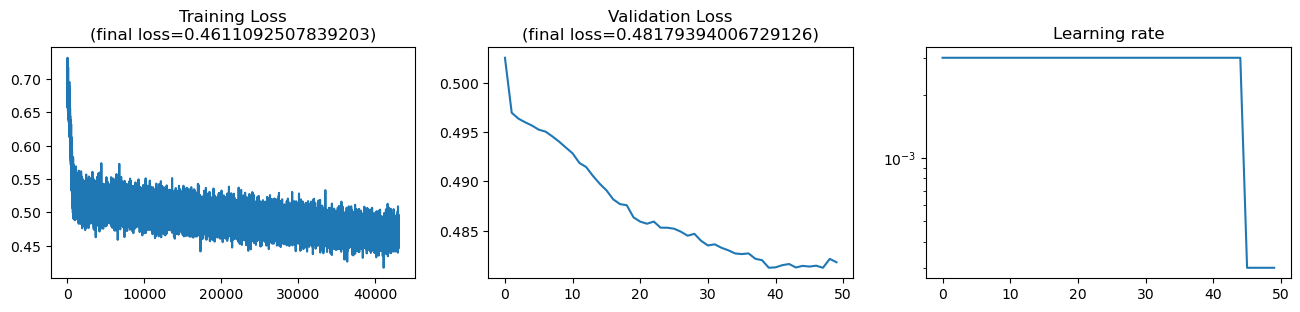

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,3))
ax1.set_title(f"Training Loss\n(final loss={train_losses[-1]})")
ax1.plot(train_losses)
ax2.set_title(f"Validation Loss\n(final loss={val_losses[-1]})")
ax2.plot(val_losses)
ax3.set_title("Learning rate")
ax3.plot(lrs)
ax3.set_yscale('log')
plt.show()

In [ ]:
lrs[-1]

# Save/Load Model

In [70]:
# Saving
torch.save({
            'epoch': epoch,
            'model_state_dict': voxels2emb.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            }, 'voxels2emb.pth')

In [ ]:
# Loading 
checkpoint = torch.load('voxels2emb.pth')
voxels2emb.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

# Visualize reconstructions
Note: you may need to restart kernel, load the model you saved in the above cell, and then run the following cells

In [68]:
# Load StyleGAN-XL
!git clone https://github.com/autonomousvision/stylegan_xl
!wget https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl

Cloning into 'stylegan_xl'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 298 (delta 75), reused 80 (delta 53), pack-reused 192
Receiving objects: 100% (298/298), 13.89 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (134/134), done.
--2022-10-28 17:59:41--  https://s3.eu-central-1.amazonaws.com/avg-projects/stylegan_xl/models/imagenet256.pkl
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.46.107
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.46.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1962430448 (1.8G) [binary/octet-stream]
Saving to: ‘imagenet256.pkl’

imagenet256.pkl     100%[===================>]   1.83G  27.5MB/s    in 72s     

2022-10-28 18:00:52 (26.1 MB/s) - ‘imagenet256.pkl’ saved [1962430448/1962430448]



In [1]:
import torch, h5py, sys
sys.path

['/workspace/git/medical/fMRI',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython']

In [2]:
sys.path.append('./stylegan_xl')

In [3]:
#!pip install ninja
#!pip install timm ftfy 
import dnnlib
import legacy

In [4]:
# Load pretrained model
network_pkl = 'imagenet256.pkl'
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
print('Using device:', device, file=sys.stderr)
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema']
    G = G.eval().requires_grad_(False).to(device)  

Loading networks from "imagenet256.pkl"...


Using device: cuda


In [5]:
import os
import torch
os.environ['CUDA_HOME'] = '/opt/conda/pkgs/cudatoolkit-11.3.1-ha36c431_9'
x = torch.rand([1, 32, 512]).cuda()
pic = G.synthesis(x, noise_mode='const')

Setting up PyTorch plugin "filtered_lrelu_plugin"... Failed!


OSError: CUDA_HOME environment variable is not set. Please set it to your CUDA install root.

In [8]:
# Load original presented images 
f = h5py.File(os.path.join(ddir, 'subj01_nsdgeneral.hdf5'), 'r')
# train_images = torch.Tensor(f['images'][train_trials]).permute(0,3,1,2)
val_images = torch.Tensor(f['images'][val_trials]).permute(0,3,1,2)
val_images = val_images[exclude_repeats]
f.close()

NameError: name 'ddir' is not defined

In [80]:
!ls ./stylegan_xl

LICENSE.txt	 environment.yml	   in_embeddings     run_stylemc.py
README.md	 feature_networks	   legacy.py	     torch_utils
__pycache__	 gen_class_samplesheet.py  media	     train.py
calc_metrics.py  gen_images.py		   metrics	     training
dataset_tool.py  gen_video.py		   pg_modules	     visualizer.py
dnnlib		 gui_utils		   run_inversion.py  viz


In [82]:
!chmod +x ./stylegan_xl/run_inversion.py

In [84]:
!./stylegan_xl/run_inversion.py --help

./stylegan_xl/run_inversion.py: 1: ./stylegan_xl/run_inversion.py: Project given image to the latent space of pretrained network pickle.: not found
./stylegan_xl/run_inversion.py: 3: ./stylegan_xl/run_inversion.py: import: not found
./stylegan_xl/run_inversion.py: 4: ./stylegan_xl/run_inversion.py: import: not found
./stylegan_xl/run_inversion.py: 5: ./stylegan_xl/run_inversion.py: from: not found
./stylegan_xl/run_inversion.py: 7: ./stylegan_xl/run_inversion.py: import: not found
./stylegan_xl/run_inversion.py: 8: ./stylegan_xl/run_inversion.py: import: not found
./stylegan_xl/run_inversion.py: 9: ./stylegan_xl/run_inversion.py: import: not found
./stylegan_xl/run_inversion.py: 10: ./stylegan_xl/run_inversion.py: import: not found
./stylegan_xl/run_inversion.py: 11: ./stylegan_xl/run_inversion.py: import: not found
./stylegan_xl/run_inversion.py: 12: ./stylegan_xl/run_inversion.py: import: not found
./stylegan_xl/run_inversion.py: 13: ./stylegan_xl/run_inversion.py: import: not found


In [ ]:
#/opt/conda/pkgs/cudatoolkit-11.3.1-ha36c431_9

In [87]:
torch.tensor(val_embs)[i].unsqueeze(0).shape

torch.Size([1, 32, 512])

In [76]:
# Depict original image / projection (i.e., best possible reconstruction) / reconstruction
voxels2emb.eval()

with torch.no_grad():
    emb_ = voxels2emb(torch.tensor(val_voxels)[:8].to(device)).reshape([8,32,512])
    
    for i in range(8):
        pic = G.synthesis(torch.tensor(val_embs)[i].unsqueeze(0).to(device), noise_mode='const')
        pic_ = G.synthesis(emb_[i].unsqueeze(0).to(device), noise_mode='const')
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,6))
        ax[0].imshow(torch_to_matplotlib(val_images[i].unsqueeze(0)))
        ax[1].imshow(torch_to_matplotlib(pic))
        ax[2].imshow(torch_to_matplotlib(pic_))
        ax[0].set_title("original\nimage")
        ax[0].axis("off")
        ax[1].set_title("latent\nprojection")
        ax[1].axis("off")
        ax[2].set_title("neural\nreconstruction")
        ax[2].axis("off")

Setting up PyTorch plugin "filtered_lrelu_plugin"... Failed!


CalledProcessError: Command '['which', 'c++']' returned non-zero exit status 1.

In [ ]:
# Depict original image / projection (i.e., best possible reconstruction) / reconstruction
voxels2emb.eval()

n = 20

with torch.no_grad():
    emb_ = voxels2emb(torch.tensor(val_voxels)[:n].to(device)).reshape([n,32,512])
    
    for i in range(n):
        pic = G.synthesis(torch.tensor(val_embs)[i].unsqueeze(0).to(device), noise_mode='const')
        pic_ = G.synthesis(emb_[i].unsqueeze(0).to(device), noise_mode='const')
        
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,6))
        ax[0].imshow(torch_to_matplotlib(val_images[i].unsqueeze(0)))
        ax[1].imshow(torch_to_matplotlib(pic))
        ax[2].imshow(torch_to_matplotlib(pic_))
        ax[0].set_title("original\nimage")
        ax[0].axis("off")
        ax[1].set_title("latent\nprojection")
        ax[1].axis("off")
        ax[2].set_title("neural\nreconstruction")
        ax[2].axis("off")

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
imgs = [torch_to_Image(val_images[i].unsqueeze(0), rescale=False) for i in range(40)]
image_grid(imgs, 10, 4)